## 一、探索性数据分析

载入本章需要用到的程序包

In [2]:
from lenskit.topn import  UnratedCandidates, ndcg, RecListAnalysis
from lenskit.batch import recommend, predict
from lenskit.crossfold import partition_users, SampleFrac, SampleN
from lenskit.algorithms.item_knn import ItemItem
from lenskit.algorithms.basic import Bias
from lenskit.metrics.predict import rmse
from lenskit.algorithms.als import BiasedMF
import lenskit
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from lenskit import *

第一个数据集是电影评分历史数据集，包含100836个样本，每个样本包含4个属性

第二个数据集是电影信息数据集，由美国运输局收集整理，包含9742个样本，每个样本包含3个属性

### 1. 数据读取

读取电影评分历史数据集ratings，修改变量名称，并查看数据集的维度和前几行。

In [3]:
ratings = pd.read_csv('./Datasets/ml-latest-small/ratings.csv')
ratings = ratings.rename(columns={'userId': 'user', 'movieId': 'item'})
print(ratings.shape)
ratings.head()

(100836, 4)


,user,item,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


读取电影信息数据集`movies`，修改变量名称，并查看数据集的维度和前几行。

In [4]:
movies = pd.read_csv('./Datasets/ml-latest-small/movies.csv')
movies = movies.rename(columns={'movieId': 'items'})
print(movies.shape)
print('\n'+ movies.head().to_string())

(9742, 3)

   items                               title                                       genres
0      1                    Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1      2                      Jumanji (1995)                   Adventure|Children|Fantasy
2      3             Grumpier Old Men (1995)                               Comedy|Romance
3      4            Waiting to Exhale (1995)                         Comedy|Drama|Romance
4      5  Father of the Bride Part II (1995)                                       Comedy


### 2. 数据聚合与连接

基于电影评分历史数据集`ratings`，按照电影（变量item）做聚合，计算各电影的平均评分和评分数量，并查看前几行

In [5]:
movie_ratings = ratings.groupby('item')['rating'].agg(['mean', 'count']) \
    .rename(columns = {'mean' : 'rating_mean', 'count' : 'rating_count'})
movie_ratings['items'] = movie_ratings.index
movie_ratings.head()

,rating_mean,rating_count,items
item,,,
1,3.920930,215,1
2,3.431818,110,2
3,3.259615,52,3
4,2.357143,7,4
5,3.071429,49,5


与电影信息数据集`movies`做内连接，添加电影的标题（变量`title`）和题材（变量`genres`），并查看前几行。

In [6]:
movie_ratings = pd.merge(movie_ratings, movies, on = 'items')
print(movie_ratings.head().to_string())

   rating_mean  rating_count  items                               title                                       genres
0     3.920930           215      1                    Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1     3.431818           110      2                      Jumanji (1995)                   Adventure|Children|Fantasy
2     3.259615            52      3             Grumpier Old Men (1995)                               Comedy|Romance
3     2.357143             7      4            Waiting to Exhale (1995)                         Comedy|Drama|Romance
4     3.071429            49      5  Father of the Bride Part II (1995)                                       Comedy


In [7]:
movie_ratings.dropna()
movie_ratings.head()

,rating_mean,rating_count,items,title,genres
0,3.920930,215,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,3.431818,110,2,Jumanji (1995),Adventure|Children|Fantasy
2,3.259615,52,3,Grumpier Old Men (1995),Comedy|Romance
3,2.357143,7,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,3.071429,49,5,Father of the Bride Part II (1995),Comedy


### 3. 电影评分分析

绘制评分的分布图。

D:\Anaconda3\envs\tensorflow_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


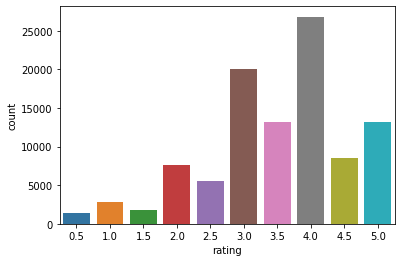

In [8]:
plt.figure()
sns.countplot(ratings['rating'])
plt.show()

绘制各电影平均评分的分布图。

D:\Anaconda3\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


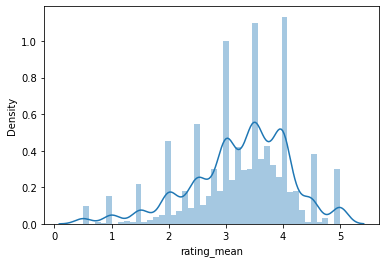

In [9]:
plt.figure()
sns.distplot(movie_ratings['rating_mean'])
plt.show()

绘制各电影评分数量的分布图。

D:\Anaconda3\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


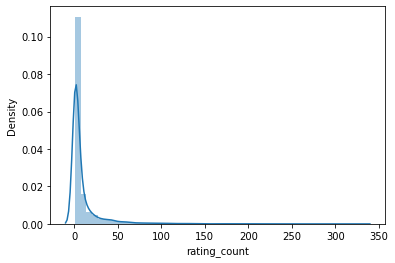

In [10]:
plt.figure()
sns.distplot(movie_ratings['rating_count'])
plt.show()

得到平均评分最高且有100条以上评分的前20部电影。

In [11]:
top20_rating_mean = movie_ratings.loc[movie_ratings['rating_count'] >= 100].\
    sort_values('rating_mean', ascending=False)[:20]

绘制这20部电影的平均评分。

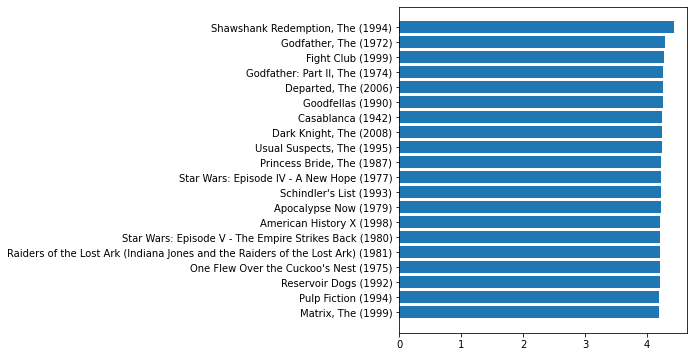

In [12]:
plt.figure(figsize=(10,6)) 
plt.subplots_adjust(left=0.5)
plt.barh(np.arange(20), top20_rating_mean["rating_mean"], align="center") 
plt.yticks(np.arange(20), top20_rating_mean["title"]) 
plt.gca().invert_yaxis()
plt.show()

得到评分数量最多的前20部电影。

In [13]:
top20_rating_count = movie_ratings.sort_values('rating_count', ascending=False)[:20]

绘制这20部电影的评分数量。

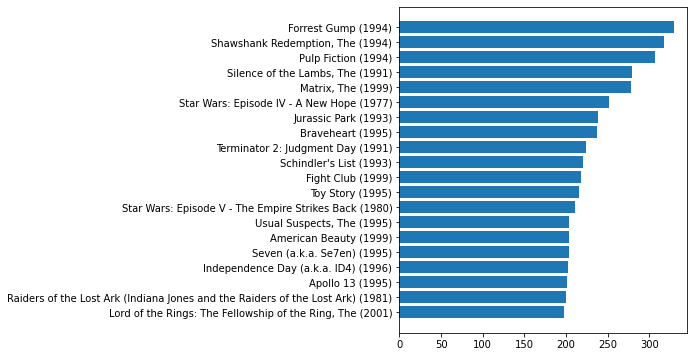

In [14]:
plt.figure(figsize=(10,6)) 
plt.subplots_adjust(left=0.5)
plt.barh(np.arange(20), top20_rating_count["rating_count"], align="center") 
plt.yticks(np.arange(20), top20_rating_count["title"]) 
plt.gca().invert_yaxis()
plt.show() 

## 二、数据预处理

### 交叉验证数据分割

将数据集分为5组训练集和测试集做5折交叉验证。在推荐系统中分割训练集和测试集时，通常按照用户而不是按照样本做分割，具体方法为：

1. 将用户分割成5组测试集用户；
2. 对于每组测试集用户，再进一步抽取这些用户20\%的评分样本作为测试集；
3. 创建对应的训练集，包含该组测试集用户得其余80\%的评分样本以及所有非测试集用户的评分样本。

调用程序包`lenskit.crossfold`中的函数`partition_users()`将数据集分割为5折交叉验证中各折对应的训练集和测试集，其中

* 第1个参数`data`表示用户评分数据框；
* 第2个参数`partitions`表示分割用户的分组数，即交叉验证的折数；
* 第3个参数`method`表示每个用户抽取评分样本的方法，这里为抽取20\%；
* 返回结果为成对训练集和测试集的迭代器。

In [15]:
np.random.seed(123)
train_folds = []
test_folds = []
for train, test in partition_users(ratings[['user', 'item', 'rating']], 5, SampleFrac(0.2)):
    train_folds.append(train)
    test_folds.append(test)

查看每组训练集和测试集的形状。

In [16]:
for i in range(5):
    print("Fold " + str(i) + ": Train - " + str(train_folds[i].shape) + ", Test - " + str(test_folds[i].shape))

Fold 0: Train - (96479, 3), Test - (4357, 3)
Fold 1: Train - (97123, 3), Test - (3713, 3)
Fold 2: Train - (96981, 3), Test - (3855, 3)
Fold 3: Train - (96982, 3), Test - (3854, 3)
Fold 4: Train - (96451, 3), Test - (4385, 3)


### 候选推荐数据准备

合并所有的测试集，为后续章节模型性能评估做准备。

In [17]:
test_all = pd.concat([test for test in test_folds], ignore_index=True)
print(test_all.head())

   user  item  rating
0     6   180     2.0
1     6   469     4.0
2     6   256     3.0
3     6   497     3.0
4     6   596     3.0


在给用户做电影推荐时，需要提供一个候选推荐列表。数据集中有部分电影只有极少数的评分，因此并不稳定，这里排出所有评分少于5条的电影。

In [18]:
item_count = ratings.groupby('item').size()
item_candidates = item_count[item_count >= 5].index.tolist()
candidates = pd.concat([ratings[['user', 'item', 'rating']], test_all]).drop_duplicates(keep=False)
candidates = candidates.loc[candidates['item'].isin(item_candidates)]
print(candidates.shape)

(72258, 3)


## 三、基于个性化平均评分的推荐

用户电影偏移量评分预测算法定义为：

$$
s(u,i) = \mu + b_i + b_u
$$

其中，$\mu$是全局平均评分，$b_i$是电影偏移量$b_u$是用户偏移量。进一步引入阻尼参数$\beta_u$和$\beta_i$，计算公式为

$$
\mu = \frac{\sum_{r_{ui} \in R} r_{ui}}{|R|} \\
b_i = \frac{\sum_{r_{ui} \in R_i} (r_{ui} - \mu)}{|R_i| + \beta_i} \\
b_u = \frac{\sum_{r_{ui} \in R_u} (r_{ui} - \mu - b_i)}{|R_u| + \beta_u}
$$

调用程序包`lenskit.algorithms.basic`中的构造函数`Bias()`创建偏移算法，其中

* 第1个参数`items`表示是否计算电影偏移量，默认为是；
* 第2个参数`users`表示是否计算用户偏移量，默认为是；
* 第3个参数`damping`表示阻尼参数。


In [20]:
algo_bias = Bias()

主要以两种方式评估推荐算法。第一种是由推荐算法预测每个用户评分最高的前$k$个电影列表，与实际该用户评分了的电影做对比，计算根据排名加权的重合度。第二种是由推荐算法预测每个用户已评分的电影的评分，与真实值做对比计算误差。

### 1. 推荐列表

遍历5组训练集和测试集，每次迭代用训练集做训练，并给测试集中的所有用户推荐每个用户评分最高的前100个电影列表。

程序包`lenskit.batch`中的函数`recommend()`用于给用户批量推荐影片，其中

* 第1个参数`algo`表示推荐算法；
* 第2个参数`users`表示需要推荐的用户列表，这里为所有测试集中的独立用户；
* 第3个参数`n`表示推荐的电影数量；
* 第4个参数`candidates`表示候选推荐列表，这里调用程序包`lenskit.topn`中的构造函数`UnratedCandidates()`返回每个用户没有评分过的电影列表。

In [21]:
recs_all = []
for i in range(5):
    train, test = train_folds[i], test_folds[i]
    algo_bias.fit(train)
    users = test.user.unique()
    recs = recommend(algo_bias, users, 100, UnratedCandidates(candidates))
    recs_all.append(recs)

合并所有测试集的推荐列表，为模型性能评估做准备。

In [22]:
recs_bias = pd.concat(recs_all, ignore_index=True)
print(recs_bias.head())

     item     score  user  rank
0    6460  5.327164     6     1
1  177593  5.077164     6     2
2   31364  5.027164     6     3
3    2239  4.927164     6     4
4    4334  4.927164     6     5


使用偏移算法的属性`mean_`、`item_offsets_`和`user_offsets_`分别得到全局平均评分$\mu$、标识符为1的电影（《玩具总动员1》）偏移量$b_i$和标识符为145的用户偏移量$b_u$。

In [23]:
print(algo_bias.mean_)   # 全局平均评分
print(algo_bias.item_offsets_[1])   # 标识符为1的电影的偏移量
print(algo_bias.user_offsets_[145])   # 标识符为145的用户偏移量

3.5002643829509283
0.4599346220241948
-0.23977443873998147


调用程序包`lenskit.topn`中的构造函数`RecListAnalysis()`创建推荐列表分析对象。进一步调用该对象的函数`add_metric`添加评价指标，这里添加的指标为归一化衰减累积增益（normalized discounted cumulative gain，简称NDCG），这里调用程序包`lenskit.metrics.topn`中的函数`ndcg()`得到。

归一化衰减累积增益定义为：

$$
\mathrm{DCG}(L,u) = \sum_{i=1}^{|L|} \frac{r_{ui}}{d(i)} \\
\mathrm{nDCG}(L, u) = \frac{\mathrm{DCG}(L,u)}{\mathrm{DCG}(L_{\mathrm{ideal}}, u)}
$$

其中，$L$是按推荐评分降序排列的电影列表，$L_{\mathrm{ideal}}$是按用户真实评分降序排列的电影列表，$u$是用户，$i$是排名，$r_{ui}$是用户$u$对排在第$i$位电影的评分。

调用推荐列表分析对象的函数`compute()`计算评价指标，其中

* 第1个参数`recs`表示推荐评分的电影列表；
* 第2个参数`truth`表示用户真实评分的电影列表；
* 返回结果为每个用户的评价指标值，这里为NDCG。

In [24]:
rla = RecListAnalysis()
rla.add_metric(ndcg)
results = rla.compute(recs_bias, test_all)
print(results.head())

      nrecs      ndcg
user                 
1     100.0  0.013261
2     100.0  0.035441
3     100.0  0.000000
4     100.0  0.042730
5     100.0  0.037237


得到所有测试集用户的NDCG均值。

In [25]:
ndcg_bias = results['ndcg'].mean()
print(ndcg_bias)

0.017595354789097562


### 2. 评分预测

遍历5组训练集和测试集，每次迭代用训练集做训练，并给测试集中的所有用户和影片组合预测评分。

程序包`lenskit.batch`中的函数`predict()`用于给用户和影片组合批量预测评分，其中

* 第1个参数`algo`表示推荐算法；
* 第2个参数`pairs`表示需要预测评分的用户和影片组合，这里为所有测试集中的用户和影片组合。

In [26]:
preds_all = []
for i in range(5):
    train, test = train_folds[i], test_folds[i]
    algo_bias.fit(train)
    preds = predict(algo_bias, test)
    preds_all.append(preds)

合并所有测试集的评分预测，为模型性能评估做准备。

In [27]:
preds_bias = pd.concat(preds_all, ignore_index=True)
print(preds_bias.head())

   user  item  rating  prediction
0     6   180     2.0    3.770021
1     6   469     4.0    3.327164
2     6   256     3.0    3.150693
3     6   497     3.0    4.122036
4     6   596     3.0    3.725312


调用程序包`lenskit.metrics.predict`中的函数`rmse()`计算预测评分与真实评分的均方根误差，其中

* 第1个参数`predictions`表示预测评分；
* 第2个参数`truth`表示真实评分。

In [28]:
rmse_bias = rmse(preds_bias['prediction'], preds_bias['rating'])
print(rmse_bias)

0.8966295630099046


## 四、基于电影相似度的协同过滤推荐

调用程序包`lenskit.algorithms.item_knn`中的构造函数`ItemItem()`创建基于电影相似度的协同过滤算法，其中

* 第1个参数`nnbrs`表示$k$近邻的数量。

In [29]:
algo_ii = ItemItem(20)

主要以两种方式评估推荐算法。第一种是由推荐算法预测每个用户评分最高的前$k$个电影列表，与实际该用户评分了的电影做对比，计算根据排名加权的重合度。第二种是由推荐算法预测每个用户已评分的电影的评分，与真实值做对比计算误差。

### 1. 推荐列表

遍历5组训练集和测试集，每次迭代用训练集做训练，并给测试集中的所有用户推荐每个用户评分最高的前100个电影列表。

In [31]:
recs_all = []
for i in range(5):
    train, test = train_folds[i], test_folds[i]
    algo_ii.fit(train)
    users = test.user.unique()
    recs = recommend(algo_ii, users, 100, UnratedCandidates(candidates))
    recs_all.append(recs)

合并所有测试集的推荐列表，为模型性能评估做准备。

In [32]:
recs_ii = pd.concat(recs_all, ignore_index=True)
print(recs_ii.head())

     item     score  user  rank
0  177593  5.330335     6     1
1    4334  5.200241     6     2
2    1178  5.164970     6     3
3  106642  5.138781     6     4
4    7156  5.124015     6     5


使用基于电影相似度的协同过滤算法的属性`sim_matrix_`得到电影的相似度矩阵，并经过一系列变换得到与标识符为1的电影（《玩具总动员1》）相似度最高的前10个电影。

In [34]:
movies = pd.read_csv('./Datasets/ml-latest-small/movies.csv')
movies = movies.rename(columns={'movieId': 'item'})

In [36]:
sim_matrix = algo_ii.sim_matrix_.to_scipy()
item_sim=np.array(sim_matrix[algo_ii.item_index_.get_loc(1),].todense()).flatten()
print(movies.set_index("item").loc[algo_ii.item_index_[item_sim.argsort()[-10:][::-1]]])

                                               title  \
item                                                   
6377                             Finding Nemo (2003)   
3114                              Toy Story 2 (1999)   
588                                   Aladdin (1992)   
8961                         Incredibles, The (2004)   
1367                           101 Dalmatians (1996)   
2731  400 Blows, The (Les quatre cents coups) (1959)   
788                      Nutty Professor, The (1996)   
6867                       Station Agent, The (2003)   
500                            Mrs. Doubtfire (1993)   
158                                    Casper (1995)   

                                           genres  
item                                               
6377          Adventure|Animation|Children|Comedy  
3114  Adventure|Animation|Children|Comedy|Fantasy  
588   Adventure|Animation|Children|Comedy|Musical  
8961   Action|Adventure|Animation|Children|Comedy  
1367           

计算测试集用户的NDCG均值。

In [37]:
rla = RecListAnalysis()
rla.add_metric(ndcg)
results = rla.compute(recs_ii, test_all)
ndcg_ii = results['ndcg'].mean()
print(ndcg_ii)

0.02351948598461819


### 2. 评分预测

遍历5组训练集和测试集，每次迭代用训练集做训练，并给测试集中的所有用户和影片组合预测评分。

In [38]:
preds_ii = []
for i in range(5):
    train, test = train_folds[i], test_folds[i]
    algo_ii.fit(train)
    preds = predict(algo_ii, test)
    preds_ii.append(preds)

合并所有测试集的评分预测，为模型性能评估做准备。

In [39]:
preds_ii = pd.concat(preds_ii, ignore_index=True)
print(preds_ii.head())

   user  item  rating  prediction
0     6   180     2.0    3.452345
1     6   469     4.0    2.994388
2     6   256     3.0    3.378852
3     6   497     3.0    4.183068
4     6   596     3.0    3.920715


调用程序包`lenskit.metrics.predict`中的函数`rmse()`计算预测评分与真实评分的均方根误差，其中

* 第1个参数`predictions`表示预测评分；
* 第2个参数`truth`表示真实评分。

In [40]:
rmse_ii = rmse(preds_ii['prediction'], preds_ii['rating'])
print(rmse_ii)

0.8490577918094997


## 五、基于矩阵分解的协同过滤推荐

该算法使用交替最小二乘法（alternating least squares）训练偏差矩阵分解，具体方法参考论文<https://dl.acm.org/citation.cfm?id=1424269>。

调用程序包`lenskit.algorithms.als`中的构造函数`BiasedMF()`创建基于矩阵分解的协同过滤算法，其中

* 第1个参数`features`表示隐因子的数量；
* 第2个参数`iterations`表示迭代次数；
* 第3个参数`reg`表示正则化参数；
* 第4个参数`damping`表示阻尼参数。

In [41]:
algo_als = BiasedMF(50)

在后续章节中，主要以两种方式评估推荐算法。第一种是由推荐算法预测每个用户评分最高的前$k$个电影列表，与实际该用户评分了的电影做对比，计算根据排名加权的重合度。第二种是由推荐算法预测每个用户已评分的电影的评分，与真实值做对比计算误差。

### 1. 推荐列表

遍历5组训练集和测试集，每次迭代用训练集做训练，并给测试集中的所有用户推荐每个用户评分最高的前100个电影列表。

In [43]:
recs_all = []
for i in range(5):
    train, test = train_folds[i], test_folds[i]
    algo_als.fit(train)
    users = test.user.unique()
    recs = recommend(algo_als, users, 100, UnratedCandidates(candidates))
    recs_all.append(recs)

In [44]:
recs_als = pd.concat(recs_all, ignore_index=True)
print(recs_als.head())

     item     score  user  rank
0    1237  4.662749     6     1
1   80906  4.630319     6     2
2    1198  4.618265     6     3
3    1235  4.609269     6     4
4  106642  4.567431     6     5


计算测试集用户的NDCG均值。

In [45]:
rla = RecListAnalysis()
rla.add_metric(ndcg)
results = rla.compute(recs_als, test_all)
ndcg_als = results['ndcg'].mean()
print(ndcg_als)

0.0775176690540789


###  2. 评分预测

遍历5组训练集和测试集，每次迭代用训练集做训练，并给测试集中的所有用户和影片组合预测评分。

In [46]:
preds_all = []
for i in range(5):
    train, test = train_folds[i], test_folds[i]
    algo_als.fit(train)
    preds = predict(algo_als, test)
    preds_all.append(preds)

合并所有测试集的评分预测，为模型性能评估做准备。

In [47]:
preds_als = pd.concat(preds_all, ignore_index=True)
print(preds_als.head())

   user  item  rating  prediction
0     6   180     2.0    3.278422
1     6   469     4.0    3.587012
2     6   256     3.0    3.263860
3     6   497     3.0    4.033837
4     6   596     3.0    3.835205


调用程序包`lenskit.metrics.predict`中的函数`rmse()`计算预测评分与真实评分的均方根误差，其中

* 第1个参数`predictions`表示预测评分；
* 第2个参数`truth`表示真实评分。

In [48]:
rmse_als = rmse(preds_als['prediction'], preds_als['rating'])
print(rmse_als)

0.8396846420032201


## 六、推荐算法的测试和评估

### 1. 归一化衰减累积增益（NDCG）

绘制3种推荐算法用于推荐列表的NDCG。可以看出，基于个性化平均评分的推荐最差，基于矩阵分解的协同过滤推荐最好。


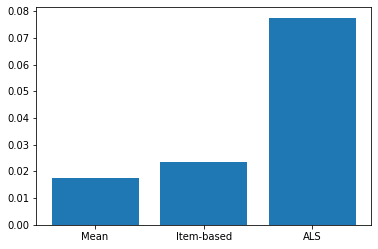

In [49]:
plt.figure()
plt.bar(['Mean','Item-based','ALS'],[ndcg_bias, ndcg_ii, ndcg_als])
plt.show()

### 2. 均方根误差

绘制3种推荐算法用于预测评分的均方根误差。可以看出，基于个性化平均评分的推荐最差，基于矩阵分解的协同过滤推荐最好。

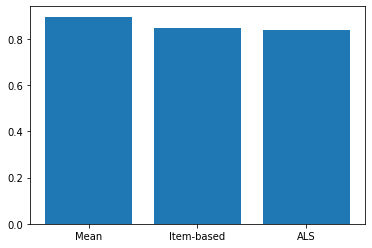

In [50]:
plt.figure()
plt.bar(['Mean','Item-based','ALS'],[rmse_bias, rmse_ii, rmse_als])
plt.show()

### 3. 推荐列表

得到标识符为145的用户在测试集中的电影列表。

In [51]:
user_145_test_items = test_all.loc[(test_all['user']==145)]['item'].tolist()
print(user_145_test_items)

[1, 153, 292, 231, 165]


查看该用户在训练集中的电影列表，这些记录输入了推荐算法用于训练。

In [52]:
print(ratings.loc[(ratings['user']==145) & (~ratings['item'].isin(user_145_test_items))].merge(movies).to_string())

    user  item  rating  timestamp                              title                                           genres
0    145    50     5.0  832105428         Usual Suspects, The (1995)                           Crime|Mystery|Thriller
1    145   111     4.0  832105479                 Taxi Driver (1976)                             Crime|Drama|Thriller
2    145   150     3.0  832105148                   Apollo 13 (1995)                             Adventure|Drama|IMAX
3    145   161     4.0  832105242                Crimson Tide (1995)                               Drama|Thriller|War
4    145   208     3.0  832105394                  Waterworld (1995)                          Action|Adventure|Sci-Fi
5    145   296     4.0  832105148                Pulp Fiction (1994)                      Comedy|Crime|Drama|Thriller
6    145   300     3.0  832105394                   Quiz Show (1994)                                            Drama
7    145   316     2.0  832105216                    Sta

In [53]:
movies = pd.read_csv('./Datasets/ml-latest-small/movies.csv')
movies = movies.rename(columns={'movieId': 'item'})

查看基于个性化平均评分推荐的前20条推荐列表

In [55]:
print(recs_bias.loc[recs_bias['user']==145].head(20).merge(movies).to_string())

      item     score  user  rank                                                                           title                        genres
0     6460  4.592158   145     1                                                  Trial, The (Procès, Le) (1962)                         Drama
1   177593  4.442158   145     2                                Three Billboards Outside Ebbing, Missouri (2017)                   Crime|Drama
2    31364  4.392158   145     3                                      Memories of Murder (Salinui chueok) (2003)  Crime|Drama|Mystery|Thriller
3     2239  4.358824   145     4  Swept Away (Travolti da un insolito destino nell'azzurro mare d'Agosto) (1975)                  Comedy|Drama
4     4406  4.317158   145     5                                        Man Who Shot Liberty Valance, The (1962)           Crime|Drama|Western
5    26131  4.317158   145     6                          Battle of Algiers, The (La battaglia di Algeri) (1966)                     Drama|War

查看电影相似度的协同过滤推荐的前20条推荐列表

In [56]:
print(recs_ii.loc[recs_ii['user']==145].head(20).merge(movies).to_string())

      item     score  user  rank                                                          title                 genres
0   183897  4.933506   145     1                                            Isle of Dogs (2018)       Animation|Comedy
1    26131  4.540056   145     2         Battle of Algiers, The (La battaglia di Algeri) (1966)              Drama|War
2   177593  4.511852   145     3               Three Billboards Outside Ebbing, Missouri (2017)            Crime|Drama
3      951  4.455785   145     4                                         His Girl Friday (1940)         Comedy|Romance
4     6460  4.426753   145     5                                 Trial, The (Procès, Le) (1962)                  Drama
5     6887  4.424838   145     6                                                   Radio (2003)                  Drama
6    55276  4.393038   145     7                                         Michael Clayton (2007)         Drama|Thriller
7     4334  4.382858   145     8                

查看基于矩阵分解的协同过滤推荐的前20条推荐列表

### 4. 评分预测

查看基于个性化平均评分推荐的评分预测。

In [57]:
print(preds_bias.loc[preds_bias['user']==145].merge(movies).to_string())

   user  item  rating  prediction                                   title                                       genres
0   145     1     5.0    3.622446                        Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1   145   153     3.0    2.610762                   Batman Forever (1995)                Action|Adventure|Comedy|Crime
2   145   292     3.0    3.114033                         Outbreak (1995)                 Action|Drama|Sci-Fi|Thriller
3   145   231     3.0    2.779459  Dumb & Dumber (Dumb and Dumber) (1994)                             Adventure|Comedy
4   145   165     3.0    3.274301       Die Hard: With a Vengeance (1995)                        Action|Crime|Thriller


查看电影相似度的协同过滤推荐的评分预测

In [58]:
print(preds_ii.loc[preds_ii['user']==145].merge(movies).to_string())

   user  item  rating  prediction                                   title                                       genres
0   145     1     5.0    3.715453                        Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1   145   153     3.0    2.539796                   Batman Forever (1995)                Action|Adventure|Comedy|Crime
2   145   292     3.0    3.075208                         Outbreak (1995)                 Action|Drama|Sci-Fi|Thriller
3   145   231     3.0    2.571410  Dumb & Dumber (Dumb and Dumber) (1994)                             Adventure|Comedy
4   145   165     3.0    3.309621       Die Hard: With a Vengeance (1995)                        Action|Crime|Thriller


查看基于矩阵分解的协同过滤推荐的评分预测

In [59]:
print(preds_als.loc[preds_als['user']==145].merge(movies).to_string())

   user  item  rating  prediction                                   title                                       genres
0   145     1     5.0    3.715347                        Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1   145   153     3.0    2.577660                   Batman Forever (1995)                Action|Adventure|Comedy|Crime
2   145   292     3.0    3.031639                         Outbreak (1995)                 Action|Drama|Sci-Fi|Thriller
3   145   231     3.0    2.537054  Dumb & Dumber (Dumb and Dumber) (1994)                             Adventure|Comedy
4   145   165     3.0    3.354366       Die Hard: With a Vengeance (1995)                        Action|Crime|Thriller
